# Extract a DEM from the planetary computer database

Planetary computer contains a catalog including dozens of different global datasets, which are easy and free to access:

https://planetarycomputer.microsoft.com/catalog


They are stored in a STAC (SpatioTemporal Asset Catalog), which is a structure to store geospatial data.


### Which Python packages do you need to install?

You'll need to install the following packages to interact with Planetary Computer's STAC:

- matplotlib (if you want to plot it)
- pystac-client
- stackstac
- dask
- xarray

All of them can be installed with pip or conda

# Raster Interpolation

In [ ]:
import rasterio
import numpy as np

url = "C:\DHI\RiverREM\outputs\FreeFlowRiverV1\add_endpnts\Copernicus_DSM_COG_10_N04_00_W078_00_centerline.tif"
# Open the raster file
with rasterio.open(url) as src:
    raster = src.read(1)  # Read the first band
    affine = src.transform


# Get coordinates and values
coordinates = np.array([(j, i) for j in range(raster.shape[1]) for i in range(raster.shape[0])])
values = raster.flatten()


# Filter out nodata values if necessary
nodata = src.nodatavals[0]
if nodata is not None:
    mask = values != nodata
    coordinates = coordinates[mask]
    values = values[mask]


from scipy.spatial.distance import cdist

def idw_interpolation(x, y, z, xi, yi, power=2):
    # Create a meshgrid for the output raster
    xi, yi = np.meshgrid(xi, yi)

    # Calculate distances between input points and output points
    distances = cdist(np.column_stack((x, y)), np.column_stack((xi.flatten(), yi.flatten())))

    # Inverse distance weighting
    weights = 1.0 / distances**power
    weights[distances == 0] = 0
    interpolated_values = np.sum(weights * z[:, None], axis=0) / np.sum(weights, axis=0)

    return interpolated_values.reshape(xi.shape)


x_coords, y_coords = coordinates[:, 0], coordinates[:, 1]
x_range = np.linspace(x_coords.min(), x_coords.max(), raster.shape[1])
y_range = np.linspace(y_coords.min(), y_coords.max(), raster.shape[0])

# Interpolate using IDW
interpolated_raster = idw_interpolation(x_coords, y_coords, values, x_range, y_range)


## JRC Surface Water 

In [3]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/jrc-gsw/items/80W_0Nv1_3_2020"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions')
asset_href = signed_item.assets["change"].href
ds = rioxarray.open_rasterio(asset_href)
ds


<xarray.DataArray (band: 1, y: 40000, x: 40000)>
[1600000000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -80.0 -80.0 -80.0 -80.0 ... -70.0 -70.0 -70.0 -70.0
  * y            (y) float64 -0.000125 -0.000375 -0.000625 ... -10.0 -10.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      value

## Sentinel-1 GRD

In [1]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20231123T103550_20231123T103617_051343_0631FB"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'vv')
asset_href = signed_item.assets["vh"].href
ds = rioxarray.open_rasterio(asset_href)
ds


<xarray.DataArray (band: 1, y: 18590, x: 25191)>
[468300690 values with dtype=uint16]
Coordinates:
  * band         (band) int32 1
    spatial_ref  int32 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:             Area
    GRD_ORIGINAL_FOOTER_SIZE:  77607
    GRD_ORIGINAL_HEADER_SIZE:  407
    TIFFTAG_DATETIME:          2023:11:23 12:26:59
    TIFFTAG_IMAGEDESCRIPTION:  Sentinel-1A IW GRD HR L1
    TIFFTAG_SOFTWARE:          Sentinel-1 IPF 003.71
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

## Sentinel-1 RTC

In [12]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-1-rtc/items/S1A_IW_GRDH_1SDV_20231111T103550_20231111T103618_051168_062BED_rtc"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'vv')
asset_href = signed_item.assets["vh"].href
ds = rioxarray.open_rasterio(asset_href)
ds


HTTPError: 403 Client Error: Forbidden for url: https://planetarycomputer.microsoft.com/api/sas/v1/token/sentinel1euwestrtc/sentinel1-grd-rtc

In [1]:
import stackstac
import dask.diagnostics
import xarray as xr
import pystac_client

# Planetary computer's STAC URL
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


In [ ]:
# import geopandas as gpd
# import rioxarray

# # We make sure that the shapefile is in the right projection
# gdf = gpd.read_file('Copenhagen.shp').to_crs('epsg:4326')

# # The geometry from the shape file
# shape_geom = gdf.loc[[0],'geometry']

#### When querying data, remember that the input geometry needs to be given as longitudes and latitudes

In [2]:
# Point data
lon, lat = 12.50 , 55.70
mygeom = dict(type = "Point", coordinates = [lon, lat])

# Polygon 
minlon, minlat, maxlon, maxlat = -79.70677443301699, -3.635295809423141, -67.29293287446059, 12.831456778731706
mygeom = dict(type = "Polygon", coordinates = [[[minlon, minlat], [minlon, maxlat], [maxlon, maxlat], [maxlon, minlat], [minlon, minlat]]])


items = catalog.search(
    intersects=mygeom,
    collections=["cop-dem-glo-30"]
    ).item_collection()


In [10]:
ids = [item['id'][:-4] for item in items.to_dict()['features']]
ids

['Copernicus_DSM_COG_10_S04_00_W080_00',
 'Copernicus_DSM_COG_10_S04_00_W079_00',
 'Copernicus_DSM_COG_10_S04_00_W078_00',
 'Copernicus_DSM_COG_10_S04_00_W077_00',
 'Copernicus_DSM_COG_10_S04_00_W076_00',
 'Copernicus_DSM_COG_10_S04_00_W075_00',
 'Copernicus_DSM_COG_10_S04_00_W074_00',
 'Copernicus_DSM_COG_10_S04_00_W073_00',
 'Copernicus_DSM_COG_10_S04_00_W072_00',
 'Copernicus_DSM_COG_10_S04_00_W071_00',
 'Copernicus_DSM_COG_10_S04_00_W070_00',
 'Copernicus_DSM_COG_10_S04_00_W069_00',
 'Copernicus_DSM_COG_10_S04_00_W068_00',
 'Copernicus_DSM_COG_10_S03_00_W080_00',
 'Copernicus_DSM_COG_10_S03_00_W079_00',
 'Copernicus_DSM_COG_10_S03_00_W078_00',
 'Copernicus_DSM_COG_10_S03_00_W077_00',
 'Copernicus_DSM_COG_10_S03_00_W076_00',
 'Copernicus_DSM_COG_10_S03_00_W075_00',
 'Copernicus_DSM_COG_10_S03_00_W074_00',
 'Copernicus_DSM_COG_10_S03_00_W073_00',
 'Copernicus_DSM_COG_10_S03_00_W072_00',
 'Copernicus_DSM_COG_10_S03_00_W071_00',
 'Copernicus_DSM_COG_10_S03_00_W070_00',
 'Copernicus_DSM

In [3]:
# Access the catalog
stack = stackstac.stack(items)
if stack.time.shape[0]>1:
    stack = stack.groupby('time').median()
stack

c:\Users\paco\AppData\Local\mambaforge\envs\stac_env\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-8d8f603e48ffb96221a673c60d3b32cb' (time: 20,
                                                                band: 1,
                                                                y: 14401,
                                                                x: 12001)>
dask.array<fetch_raster_window, shape=(20, 1, 14401, 12001), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2021-04-22 2021-04-22 ... 2021-04-22
    id          (time) <U40 'Copernicus_DSM_COG_10_N57_00_E012_00_DEM' ... 'C...
  * band        (band) <U4 'data'
  * x           (x) float64 8.0 8.0 8.0 8.001 8.001 ... 13.0 13.0 13.0 13.0 13.0
  * y           (y) float64 58.0 58.0 58.0 58.0 58.0 ... 54.0 54.0 54.0 54.0
    proj:epsg   int32 4326
    gsd         int32 30
    platform    <U8 'TanDEM-X'
    proj:shape  object {3600, 2400}
    epsg        int32 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(7.999583333333333, 54.0, 13...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 8.00|\n| 0.00,-0.00, 58.00|\n| 0.00, 0.00, ...
    resolution_xy:  (0.00041666666666666664, 0.0002777777777777778)

In [6]:
# Download the data locally
with dask.diagnostics.ProgressBar():
    cop_dem = stack.compute()


[#####################################   ] | 92% Completed | 64.37 ss

c:\Users\paco\AppData\Local\mambaforge\envs\stac_env\lib\site-packages\dask\utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


[########################################] | 100% Completed | 114.00 s


In [8]:
# # # If needed, stitch the DEM together
# # if cop_dem.time.shape[0] > 1:
# #     cop_dem = cop_dem.groupby('time').median()

# Select only the relevant dimensions
cop_dem = cop_dem.sel(time = cop_dem.time[0], band = 'data')

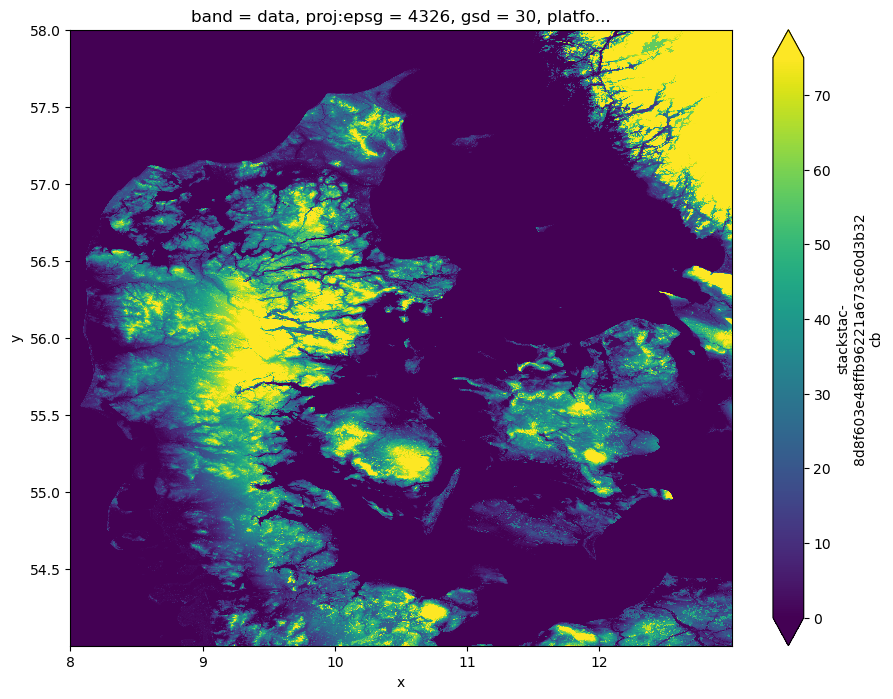

In [9]:
# Here is what it looks like!
cop_dem.plot.imshow(vmin = 0, vmax = 75, size = 8)

## Add-up : load an area from a shapefile and clip it to the specific area

Requires the following additional python packages:
- geopandas
- rioxarray

In [7]:
import geopandas as gpd
import rioxarray

# We make sure that the shapefile is in the right projection
gdf = gpd.read_file('Copenhagen.shp').to_crs('epsg:4326')

# The geometry from the shape file
shape_geom = gdf.loc[[0],'geometry']

In [8]:
items = catalog.search(
    intersects=shape_geom.loc[0],
    collections=["cop-dem-glo-30"]
    ).item_collection()


# Access the catalog
stack = stackstac.stack(items)

# Clip the data to the input shape
stack = stack.rio.clip(shape_geom.to_crs(stack.crs))

# And query the data
with dask.diagnostics.ProgressBar():
    copenhagen_dem = stack.compute()

if copenhagen_dem.time.shape[0] > 1:
    copenhagen_dem = copenhagen_dem.groupby('time').median()


copenhagen_dem = copenhagen_dem.sel(time = copenhagen_dem.time[0], band = 'data')

[                                        ] | 0% Completed | 726.40 us

c:\Users\paco\AppData\Local\mambaforge\envs\stac_env\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


[########################################] | 100% Completed | 681.73 ms


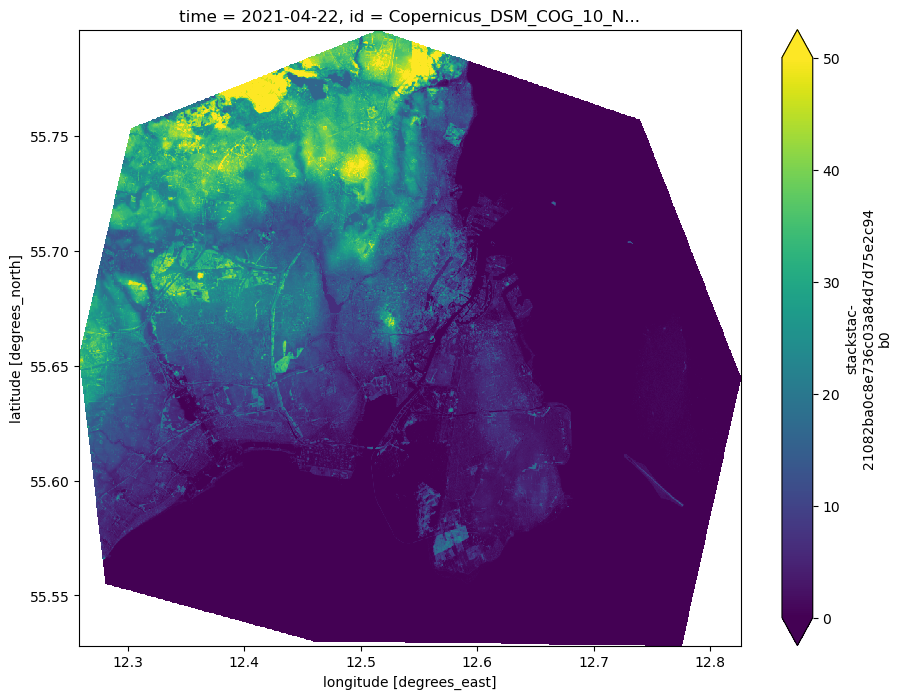

In [9]:
copenhagen_dem.plot.imshow(vmin = 0, vmax = 50, size = 8)

#### Save the data as a tif

For this you only need the rasterio package, which is installed together with the requirements from the previous packages

### If the dem was *not* clipped

In [10]:
import rasterio

output_name = 'Sjaelland_DEM.tif'

with rasterio.open(output_name, 'w', driver = 'GTiff', count = 1, 
                    height = cop_dem.shape[0], width  = cop_dem.shape[1],
                    dtype  = cop_dem.dtype,  crs = cop_dem.crs,  transform = cop_dem.transform) as output:
    output.write(cop_dem.values, 1)


### If it was clipped

In [20]:
import rasterio

output_name = 'Copenhagen_DEM.tif'

out_crs = 'epsg:'+str(copenhagen_dem.spec.epsg)

out_transform = rasterio.Affine(copenhagen_dem.resolution_xy[0], 0, copenhagen_dem.x.values[0], 
                                 0, -copenhagen_dem.resolution_xy[1], copenhagen_dem.y.values[0])

with rasterio.open(output_name, 'w', driver = 'GTiff', count = 1, 
                    height = copenhagen_dem.shape[0], width  = copenhagen_dem.shape[1],
                    dtype  = copenhagen_dem.dtype,  crs = out_crs,  transform = out_transform) as output:
    output.write(copenhagen_dem.values, 1)


In [11]:
import os

output_url = "/Users/puzhao/PyProjects/DHI/RiverREM/outputs/Copernicus_DSM_COG_10_N02_00_W072_00_REM.tif"
cog_url = "/Users/puzhao/PyProjects/DHI/RiverREM/outputs/Copernicus_DSM_COG_10_N02_00_W072_00_REM_COG.tif"
os.system(f"gdal_translate {output_url} {cog_url} -co TILED=YES -co COPY_SRC_OVERVIEWS=YES -co COMPRESS=LZW")

Input file size is 3600, 3600
0...10...20...30...40...50...60...70...80...90...100 - done.


0